<center> <b>UCGIS I-GUIDE Community Champion Project</b> </center>


# 2020 Census and Differential Privacy
<i>Yue Lin, The Ohio State University</i>

Census data are one of the largest public data sources in the United States, which contain detailed demographic information and have widely been used to redraw voting districts, direct federal funding, and inform policymaking and research. [Title 13 of the United States Code](https://www.census.gov/history/www/reference/privacy_confidentiality/title_13_us_code.html#:~:text=People%20sworn%20to%20uphold%20Title,is%20a%20serious%20federal%20crime) states that federal agencies are not permitted to release personally identifiable information from the census. However, this becomes increasingly challenging because the advances in computing power and the availability of commercial data sets have made it easier to link ostensibly anonymized census data to specific individuals. 

To enhance individual privacy protection in the 2020 Census, the Census Bureau established a privacy protection system based on a mathematical concept known as [differential privacy](https://en.wikipedia.org/wiki/Differential_privacy). Developed at Microsoft Research, differential privacy has become the gold standard for data privacy in various applications from both private and public sectors. This notebook describes the use of differential privacy for census data as well as how it will affect the census data.

**Related Topics in GIS&T Body of Knowledge:** [United States Census Data](https://doi.org/10.22224/gistbok/2019.1.8), [Location Privacy](http://dx.doi.org/10.22224/gistbok/2016.3.2)

## Notebook Outline
- [Differential Privacy for Census Data](#sec1)
- [How will Differential Privacy Affect the Census Data?](#sec2)
    - [Affine Transformation](#geomasking1)
    - [Random Perturbation](#geomasking2)
    - [Gaussian Perturbation](#geomasking3)
    - [Donut Masking](#geomasking4)
- [References](#ref)

<a id='sec1'></a>
## Differential Privacy for Census Data
Differential privacy seeks to conceal the presence or absence of any individual (or small groups of individuals) in a database while preserving statistical utility. A general way to achieve differential privacy is to add “noise” to the collected data. In the 2020 United States Census, statistical noise is sampled from a Gaussian distribution and added to census data at each geographical level (from the nation, to states, down to census blocks). The amount of statistical noise added is controlled by a “privacy loss budget”, which defines the maximum amount of privacy loss that can occur upon the release of census data. As the privacy loss budget increases, the added noise decreases, implying that the census data will be more accurate, but the likelihood of private information being exploited using the census data also increases.

<img src='./figs/dp.png' width='600'/>

Source: [Disclosure Avoidance for the 2020 Census: An Introduction.](https://www2.census.gov/library/publications/decennial/2020/2020-census-disclosure-avoidance-handbook.pdf)

<a id='sec2'></a>
## How will Differential Privacy Affect Census Data?

Various geographic masking techniques have been developed over the years. All of these include some level of randomization to reduce the probability of identifying an individual based on his or her geographic locations. We here demonstrate the use of five commonly used geomasking techniques: affine transformations, random perturbation, Gaussian perturbation, donut masking, and location swapping.

<a id='geomasking1'></a>
### Affine Transformation
Affine transformation is a set of methods for deterministically moving individual locations to a new set of locations using translation (moving each point by a fixed offset from its original location), change of scale (multiplying the coordinates of each point by a scaling constant), and rotation (rotating each point by a fixed angle about a pivot point)[<sup>1</sup>](#fn1).

In [ ]:
import pandas as pd
import geopandas as gpd

# Read boundary data
filename_poly = 'data/tl_2020_39059_tabblock10.shp'
poly = gpd.read_file(filename_poly)
poly = poly.to_crs('EPSG:3395')

# Read individual point locations
filename_df = 'data/guernsey_data.csv'
df = pd.read_csv(filename_df)
df['Block'] = df['Block'].astype(str)
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(x=df.lon, y=df.lat)).set_crs('EPSG:4326')
gdf = gdf.to_crs('EPSG:3395')

# Plot
base = poly.plot(color='white', edgecolor='black')
ax = gdf.plot(ax=base, markersize=0.1) 
ax.set_axis_off()

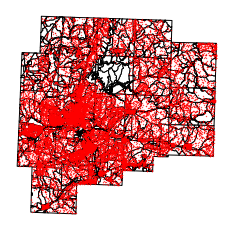

In [11]:
from shapely.geometry import Point
from shapely import affinity

# Set user-defined transformation parameters
# Translation offset
offset = 50
# Scaling factor
factor = 1.1
# Angle of rotation
angle = 90

# Move each point using affine transformation
gdf_at = gdf.copy()
for index, row in gdf_at.iterrows():
    # Translation
    pt = affinity.translate(row['geometry'], xoff=offset, yoff=offset)
    # Change of scale
    new_pt = affinity.scale(pt, xfact=factor, yfact=factor)
    # Rotation
    new_pt = affinity.rotate(new_pt, angle)
    gdf_at.at[index, 'geometry'] = new_pt

# Plot
base = poly.plot(color='white', edgecolor='black')
ax = gdf_at.plot(ax=base, markersize=0.1, color='red') 
ax.set_axis_off()

Zooming in to Block 390599773001005:

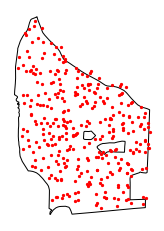

In [12]:
# Plot
base = poly.loc[[1610],'geometry'].plot(color='white', edgecolor='black')
ax = gdf_at[gdf_at['Block'] == blockid].plot(ax=base, markersize=5, color='red') 
ax.set_axis_off()

<a id='geomasking2'></a>
### Random Perturbation
Adding randomized noise to the original coordinates is a common way to protect the location privacy of individual-level data[<sup>1</sup>](#fn1)[<sup>2</sup>](#fn2). Each point location can be placed at random within a circle with a center at the original point and a radius defined by the user, or within any other polygon defined relative to the original point. We here illustrate the use of perturbation polygon for privacy protection.

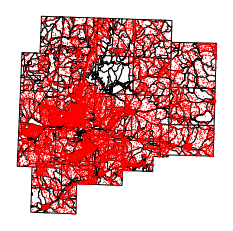

In [3]:
import random
from shapely.geometry import Point

# Set user-defined radius
radius = 50     

def get_random_point_in_polygon(buf):
    """Obtain a random point within the polygon (buffer).

    buf: A polygon with a center at the original point and a user-defined radius

    Returns:
    p: Coordinates of the point with random noise added
    """
    minx, miny, maxx, maxy = buf.bounds
    while True:
        pt = Point(random.uniform(minx, maxx), random.uniform(miny, maxy))
        if buf.contains(pt):
            return pt

# Obtain perturbation polygons
gdf_rp = gdf.copy()
buf = gdf_rp.buffer(radius)

# Move each point at random within the polygon
for index, row in buf.iteritems():
    new_pt = get_random_point_in_polygon(row)
    gdf_rp.at[index, 'geometry'] = new_pt

# Plot
base = poly.plot(color='white', edgecolor='black')
ax = gdf_rp.plot(ax=base, markersize=0.1, color='red') 
ax.set_axis_off()

Zooming in to Block 390599773001005:

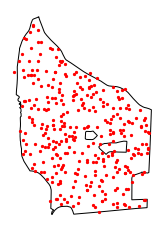

In [4]:
# Plot
base = poly.loc[[1610],'geometry'].plot(color='white', edgecolor='black')
ax = gdf_rp[gdf_rp['Block'] == blockid].plot(ax=base, markersize=5, color='red') 
ax.set_axis_off()

<a id='geomasking3'></a>
### Gaussian Perturbation
Allowing the distance of displacement to follow a certain distribution, such as Gaussian or uniform, is another way to achieve displacement[<sup>3</sup>](#fn3). The code below shows how to move each point according to a Gaussian distribution.

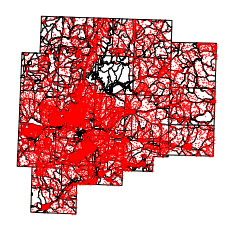

In [17]:
import random
import numpy as np

# Set standard deviation
sigma = 50

# Displace each point following a Gaussian distribution
gdf_gp = gdf.copy()
for index, row in gdf_gp.iterrows():
    pt = row['geometry']
    new_pt = Point(pt.x + np.random.normal(0, sigma, 1), pt.y + np.random.normal(0, sigma, 1))
    gdf_gp.at[index, 'geometry'] = new_pt

# Plot
base = poly.plot(color='white', edgecolor='black')
ax = gdf_gp.plot(ax=base, markersize=0.1, color='red') 
ax.set_axis_off()

Zooming in to Block 390599773001005:

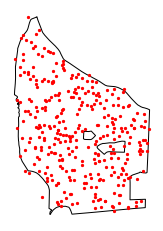

In [18]:
# Plot
base = poly.loc[[1610],'geometry'].plot(color='white', edgecolor='black')
ax = gdf_gp[gdf_gp['Block'] == blockid].plot(ax=base, markersize=5, color='red') 
ax.set_axis_off()

<a id='geomasking4'></a>
### Donut Masking
We define a maximum distance for shifting particular individual locations in random perturbation. Donut masking extends this method by incorporating a minimum distance of displacement, ensuring a user-defined minimum level of privacy protection[<sup>4</sup>](#fn4).

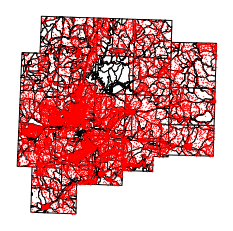

In [19]:
import random
from shapely.geometry import Point

# Set user-defined radius
radius_in = 10
radius_out = 50

def get_random_point_in_donut(buf_in, buf_out):
    """Obtain a random point within the donut (buffer).

    buf_in: The inner polygon with a radius of the minimum displacement distance
    buf_out: The outer polygon with a radius of the maximum displacement distance

    Returns:
    p: Coordinates of the point with random noise added
    """
    minx, miny, maxx, maxy = buf_out.bounds
    while True:
        pt = Point(random.uniform(minx, maxx), random.uniform(miny, maxy))
        if buf_out.contains(pt) and not buf_in.contains(pt):
            return pt

# Obtain perturbation donuts
gdf_dm = gdf.copy()
buf_in = gdf_dm.buffer(radius_in)
buf_out = gdf_dm.buffer(radius_out)

# Move each point at random within the donut
for index, row in gdf_dm.iterrows():
    poly_in = buf_in.iloc[index]
    poly_out = buf_out.iloc[index]
    new_pt = get_random_point_in_donut(poly_in, poly_out)
    gdf_dm.at[index, 'geometry'] = new_pt

# Plot
base = poly.plot(color='white', edgecolor='black')
ax = gdf_dm.plot(ax=base, markersize=0.1, color='red') 
ax.set_axis_off()

Zooming in to Block 390599773001005:

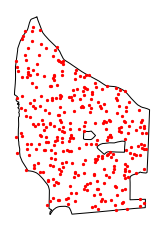

In [20]:
# Plot
base = poly.loc[[1610],'geometry'].plot(color='white', edgecolor='black')
ax = gdf_dm[gdf_dm['Block'] == blockid].plot(ax=base, markersize=5, color='red') 
ax.set_axis_off()

<a id='ref'></a>
## References
<span id="fn1"> Armstrong, M. P., Rushton, G., & Zimmerman, D. L. (1999). Geographically masking health data to preserve confidentiality. Statistics in Medicine, 18(5), 497-525. </span>

<span id="fn2"> Kwan, M. P., Casas, I., & Schmitz, B. (2004). Protection of geoprivacy and accuracy of spatial information: How effective are geographical masks?. Cartographica: The International Journal for Geographic Information and Geovisualization, 39(2), 15-28. </span>

<span id="fn3"> Cassa, C. A., Wieland, S. C., & Mandl, K. D. (2008). Re-identification of home addresses from spatial locations anonymized by Gaussian skew. International Journal of Health Geographics, 7(1), 1-9. </span>

<span id="fn4"> Hampton, K. H., Fitch, M. K., Allshouse, W. B., Doherty, I. A., Gesink, D. C., Leone, P. A., ... & Miller, W. C. (2010). Mapping health data: improved privacy protection with donut method geomasking. American Journal of Epidemiology, 172(9), 1062-1069. </span>